In [86]:
import pandas as pd
train_df = pd.read_csv("/Users/kaylenamann/Downloads/BC Grad/2025Fall_ADAN7430/assignments/HW2/RawData/train.csv")
print(train_df.head())
print(train_df.info())

   id  gender   age  hypertension  heart_disease ever_married work_type  \
0   1    Male  50.0             0              0          Yes   Private   
1   2  Female  52.0             0              0          Yes   Private   
2   3  Female  26.0             0              0           No  Govt_job   
3   4  Female  37.0             0              0          Yes   Private   
4   5    Male  59.0             0              0          Yes   Private   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Rural              88.10  29.1  formerly smoked       0  
1          Rural              80.07  38.9           smokes       0  
2          Urban              89.11  23.3           smokes       0  
3          Rural              81.36  36.1     never smoked       0  
4          Rural              82.59  29.6     never smoked       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12243 entries, 0 to 12242
Data columns (total 12 columns):
 #   Column             No

In [100]:
import statsmodels.api as sm
feature_cols = ['gender', 'age', 'hypertension', 'heart_disease', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']
X = pd.get_dummies(train_df[feature_cols], drop_first=True)
y = train_df['stroke']
X = sm.add_constant(X, has_constant='add')
X = X.astype(float)

In [108]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=39, stratify=y)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

cont = [c for c in ["age", "bmi", "avg_glucose_level"] if c in X_train.columns]
means = X_train[cont].mean()

for c in cont:
    mean_c = X_train[c].mean()
    X_train[c] = X_train[c] - mean_c
    X_test[c] = X_test[c] - mean_c

X_train["age_bmi_int"] = X_train["age"] * X_train["bmi"]
X_test["age_bmi_int"] = X_test["age"] * X_test["bmi"]

X_train["gluc_hypter_int"] = X_train["avg_glucose_level"] * X_train["hypertension"]
X_test["gluc_hypter_int"] = X_test["avg_glucose_level"] * X_test["hypertension"]

for col in X_train.columns:
    if 'smoking_status_' in col:  
        X_train[f'age_{col}_int'] = X_train['age'] * X_train[col]
        X_train[f'heart_{col}_int'] = X_train['heart_disease'] * X_train[col]
        X_test[f'age_{col}_int'] = X_test['age'] * X_test[col]
        X_test[f'heart_{col}_int'] = X_test['heart_disease'] * X_test[col]

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

continuous_vars = ['age', 'avg_glucose_level', 'bmi']

model_original = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results_original = model_original.fit()

X_train_bt = X_train.copy()
for var in continuous_vars:
    X_train_bt[f'{var}_logint'] = X_train_bt[var] * np.log(X_train_bt[var] + 1)
    
model_bt = sm.GLM(y_train, X_train_bt, family=sm.families.Binomial())
results_bt = model_bt.fit()

print("Original AIC:", results_original.aic)
print("Box–Tidwell AIC:", results_bt.aic)
print("\nBox–Tidwell model summary:")
print(results_bt.summary())

/opt/anaconda3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


MissingDataError: exog contains inf or nans

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import get_scorer_names

from sklearn.preprocessing import StandardScaler

cols_to_scale = [c for c in ["age_c", "bmi_c", "avg_glucose_level_c", "age_bmi_int", "gluc_hypter_int"]
                 if c in X_train.columns]

scaler = StandardScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale]  = scaler.transform(X_test[cols_to_scale])

scorer = make_scorer(f1_score, pos_label=1)
base_model = LogisticRegression(max_iter=2000, class_weight="balanced")
model = TunedThresholdClassifierCV(base_model, scoring=scorer, cv=5)
scorer(model.fit(X_train, y_train), X_train, y_train)

0.3174846625766871

In [103]:
print(model.best_threshold_)
print(model.best_score_)

0.7611321933478461
0.3159005288165216


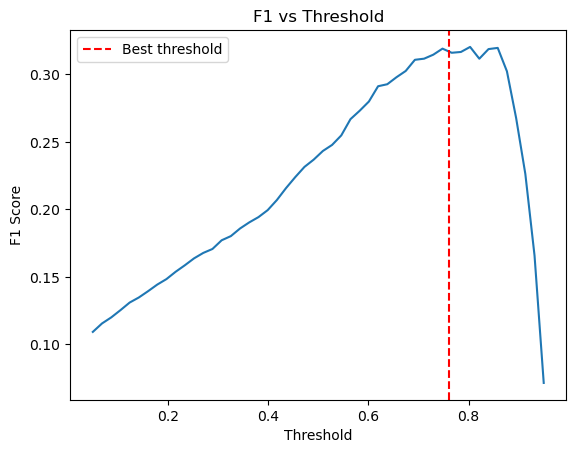

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

probs = model.estimator_.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0.05, 0.95, 50)
f1s = [f1_score(y_test, (probs >= t).astype(int)) for t in thresholds]

plt.plot(thresholds, f1s)
plt.axvline(model.best_threshold_, color='red', linestyle='--', label='Best threshold')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 vs Threshold")
plt.legend()
plt.show()

In [105]:
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, recall_score, precision_score,
    precision_recall_curve, auc
)

y_pred_final = model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_final))
print("Classification Report:\n", classification_report(y_test, y_pred_final, digits=3))
print("Accuracy:", accuracy_score(y_test, y_pred_final))
print("ROC AUC:", roc_auc_score(y_test, probs))

prec, rec, thr = precision_recall_curve(y_test, probs)
pr_auc = auc(rec, prec)
print("PR-AUC:", pr_auc)

Confusion Matrix:
 [[3198  323]
 [  62   90]]
Classification Report:
               precision    recall  f1-score   support

           0      0.981     0.908     0.943      3521
           1      0.218     0.592     0.319       152

    accuracy                          0.895      3673
   macro avg      0.599     0.750     0.631      3673
weighted avg      0.949     0.895     0.917      3673

Accuracy: 0.895181050912061
ROC AUC: 0.8806540456509065
PR-AUC: 0.24705379475083256


In [43]:
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, recall_score, precision_score,
    precision_recall_curve, auc
)
glm_smote_model = sm.GLM(y_train_sm, X_train_sm, family=sm.families.Binomial())
glm_smote_results = glm_smote_model.fit()
print(glm_smote_results.summary())
X_test_aligned = X_test.reindex(columns=X_train_sm.columns, fill_value=0)
probs_smote = glm_smote_results.predict(X_test_aligned)
glm_smote_pred = (probs_smote >= 0.4).astype(int)
print("Accuracy:", accuracy_score(y_test, glm_smote_pred))
print("Classification Report:\n", classification_report(y_test, glm_smote_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, glm_smote_pred))
print("ROC AUC:", roc_auc_score(y_test, probs))

prec, rec, thr = precision_recall_curve(y_test, probs)
pr_auc = auc(rec, prec)
print("PR-AUC:", pr_auc)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 stroke   No. Observations:                16432
Model:                            GLM   Df Residuals:                    16415
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5932.0
Date:                Wed, 15 Oct 2025   Deviance:                       11864.
Time:                        20:19:50   Pearson chi2:                 1.44e+04
No. Iterations:                    26   Pseudo R-squ. (CS):             0.4854
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

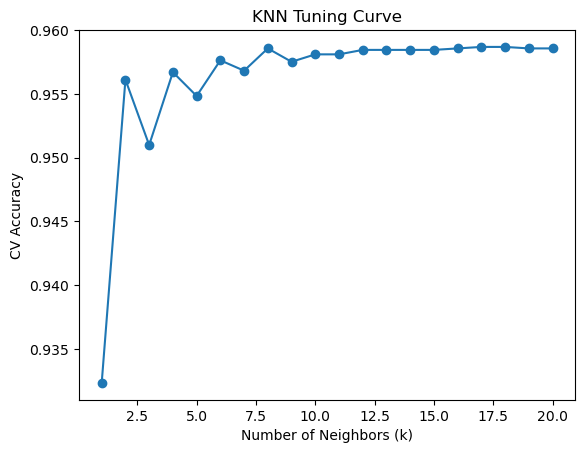

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

k_values = range(1, 21)
cv_scores = []
for k in k_values:
    knn_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    scores = cross_val_score(knn_pipe, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

import matplotlib.pyplot as plt
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('CV Accuracy')
plt.title('KNN Tuning Curve')
plt.show()

In [45]:
knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=7))
])
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

k_values = range(1, 21)
cv_scores = []

In [26]:
print("KNN Accuracy:", accuracy_score(y_test, knn_pred))
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, knn_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, knn_pred))

KNN Accuracy: 0.9575279063435883
KNN Confusion Matrix:
 [[3514    7]
 [ 149    3]]

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      3521
           1       0.30      0.02      0.04       152

    accuracy                           0.96      3673
   macro avg       0.63      0.51      0.51      3673
weighted avg       0.93      0.96      0.94      3673

